In [3]:
import rasterio as rio
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rasterstats import zonal_stats
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

raster_dir = '/home/mcoving/Dropbox/sync/projects/Dolines/comparison_data/chelsa_v2/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/'

raster_key = pd.read_excel('raster-data-key.xlsx', index_col=0)

p_karst_df = gpd.read_file('share/analysis-layers/processed_hucs.shp')
# Raster data is in EPSG:4326
p_karst_df_4326 = p_karst_df.to_crs("4326")

def add_raster_stats_to_df(df, parameter, raster_dir=raster_dir, raster_key=raster_key):
    raster_filename = raster_key['filename'][parameter]
    full_raster_path = os.path.join(raster_dir, raster_filename)
    scale = raster_key['scale'][parameter]
    offset = raster_key['offset'][parameter]

    with rio.open(full_raster_path) as src:
        affine = src.transform
        array = src.read(1)
        df_zonal_stats = pd.DataFrame(zonal_stats(p_karst_df_4326, array, affine=affine, all_touched=True))
        df[parameter] = df_zonal_stats['mean'].values * scale + offset
    
    return df

# pretty print key
raster_key


,scale,offset,filename
parameter,,,
mean annual temp,0.10,-273.15,CHELSA_bio1_1981-2010_V.2.1.tif
mean diurnal temp range,0.10,0.00,CHELSA_bio2_1981-2010_V.2.1.tif
isothermality,0.10,0.00,CHELSA_bio3_1981-2010_V.2.1.tif
temperature seasonality,0.10,0.00,CHELSA_bio4_1981-2010_V.2.1.tif
annual precipitation,0.10,0.00,CHELSA_bio12_1981-2010_V.2.1.tif
precipitation seasonality,0.10,0.00,CHELSA_bio15_1981-2010_V.2.1.tif
net primary productivity,0.10,0.00,CHELSA_npp_1981-2010_V.2.1.tif
monthly mean pet,0.01,0.00,CHELSA_pet_penman_mean_1981-2010_V.2.1.tif


In [3]:
for param in raster_key.index:
    print("Processing " + param +'...')
    p_karst_df_4326 = add_raster_stats_to_df(p_karst_df_4326, param)

Processing mean annual temp...


/home/mcoving/anaconda3/envs/geo/lib/python3.9/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Processing mean diurnal temp range...
Processing isothermality...
Processing temperature seasonality...
Processing annual precipitation...
Processing precipitation seasonality...
Processing net primary productivity...
Processing monthly mean pet...


In [4]:
p_karst_df_4326.to_file('processed_hucs_with_climate_4326.shp')

/tmp/ipykernel_264161/1967637734.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  p_karst_df_4326.to_file('processed_hucs_with_climate_4326.shp')


In [36]:
p_karst = p_karst_df_4326.p_karst
indep_vars = raster_key.index.values
controls_df = p_karst_df_4326[indep_vars]
controls_df

KeyError: "None of [Index(['mean annual temp', 'mean diurnal temp range', 'isothermality',\n       'temperature seasonality', 'annual precipitation',\n       'precipitation seasonality', 'net primary productivity',\n       'monthly mean pet'],\n      dtype='object')] are in the [columns]"

In [6]:
p_karst

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29063    0.0
29064    0.0
29065    0.0
29066    0.0
29067    0.0
Name: p_karst, Length: 29068, dtype: float64

In [46]:
def make_displot(param, 
                 p_karst, 
                 controls_df, 
                 trim_zero=True, 
                 trim_to_min_value = 0,
                 set_zero_to=None,
                 xlabel=None, 
                 ylabel='Percentage karst drained', 
                 log_scale=(False,True),
                 calculate_correlation='Spearman',):
    if set_zero_to is not None:
        p_karst[p_karst==0] = set_zero_to
    
    if trim_to_min_value>0:
        wantidx = p_karst>trim_to_min_value
        x = controls_df[param][wantidx]
        y = p_karst[wantidx]
    elif trim_zero:
        non_zero_p_karst = p_karst>0
        x = controls_df[param][non_zero_p_karst]
        y = p_karst[non_zero_p_karst]    
    else:
        x = controls_df[param]
        y = p_karst
    

    sns.displot(x=x,
            y=y,
            log_scale=log_scale,
            )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    rstring = None
    if calculate_correlation == 'Spearman':
        r, p = spearmanr(x, y)
        rstring = 'rho='+str(r)[:5]
    if calculate_correlation == 'Pearson':
        r, p = pearsonr(x, y)
        rstring = 'R='+str(r)[:5]
    if rstring is not None:
        ax = plt.gca()
        plt.text(0.05,0.95, rstring, transform = ax.transAxes)



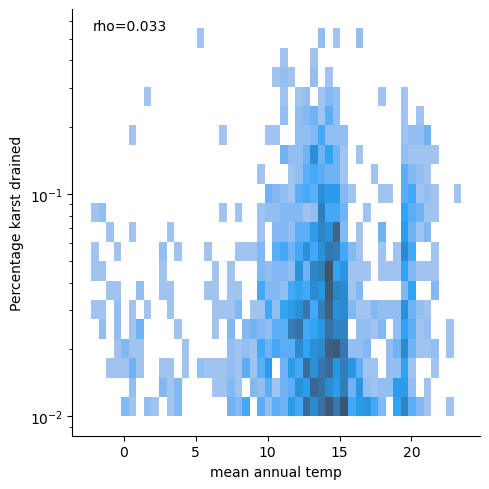

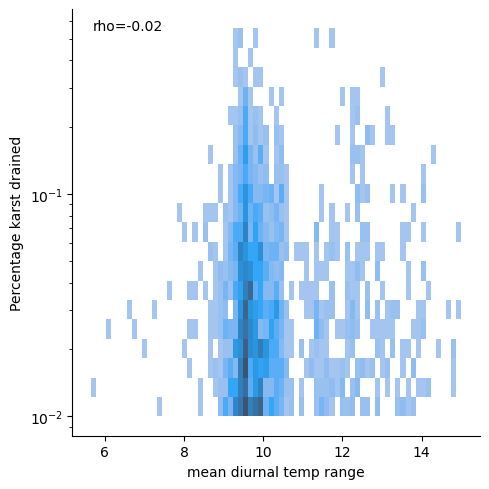

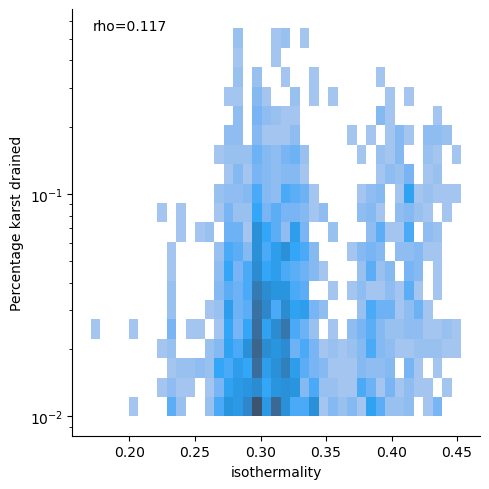

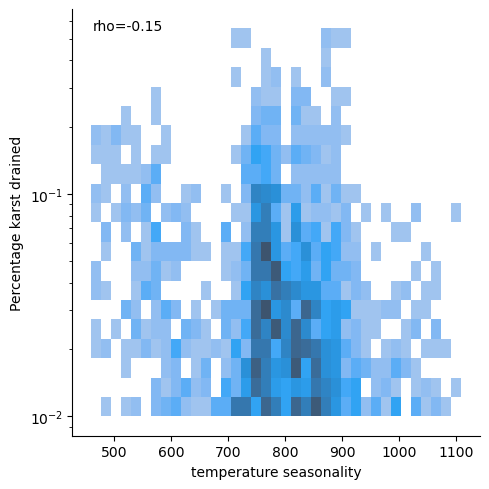

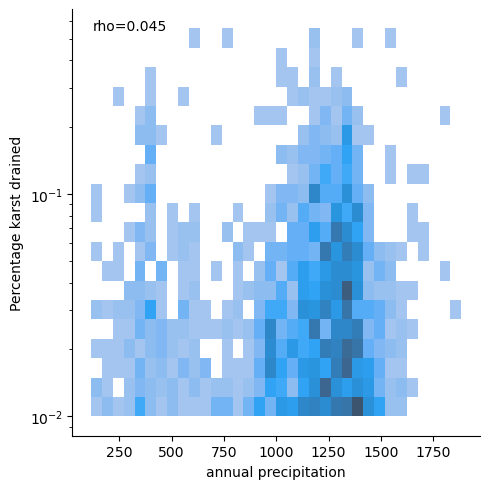

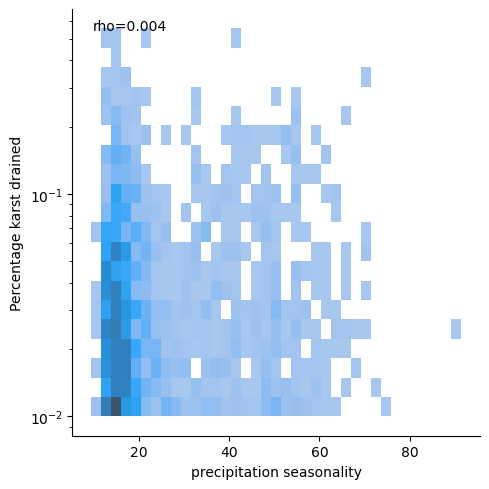

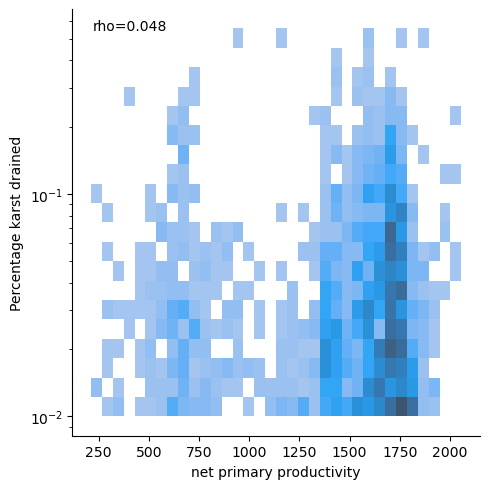

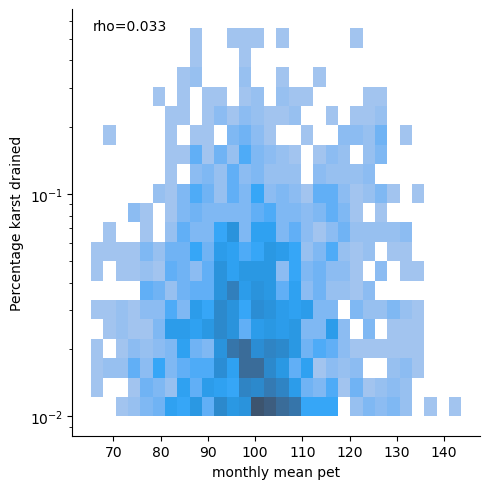

In [11]:
for param in raster_key.index:
     make_displot(param, 
             p_karst.copy(), 
             controls_df,
             trim_to_min_value=0.01,
             trim_zero=False,
             set_zero_to=1e-7
        )

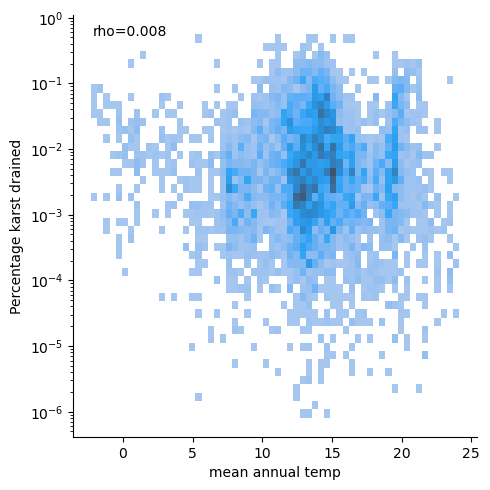

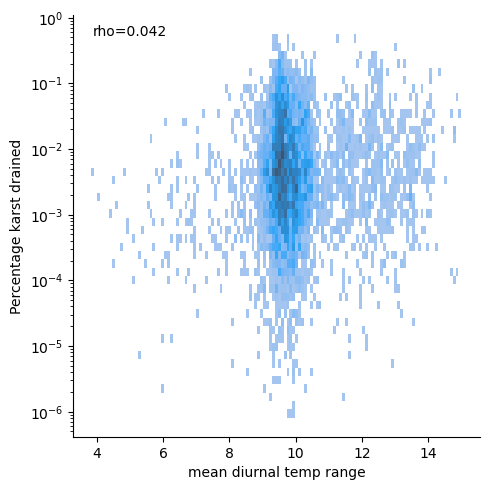

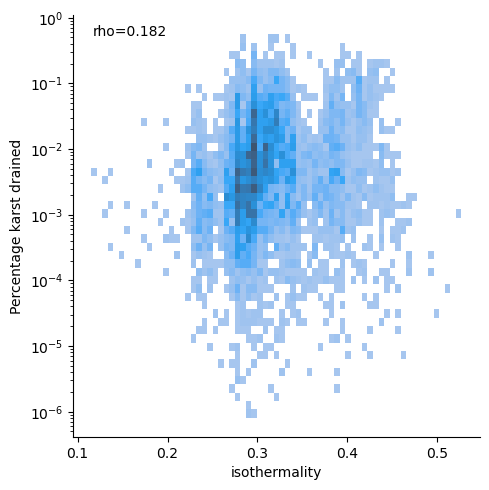

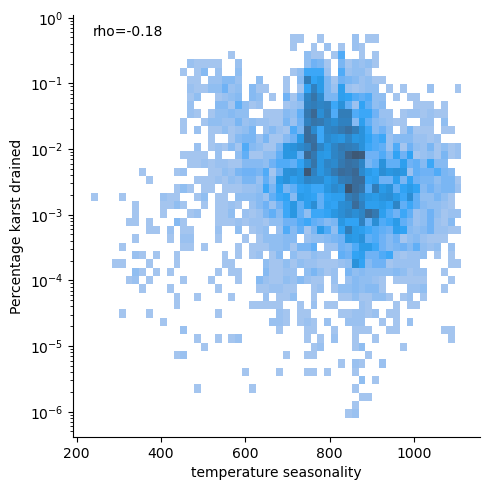

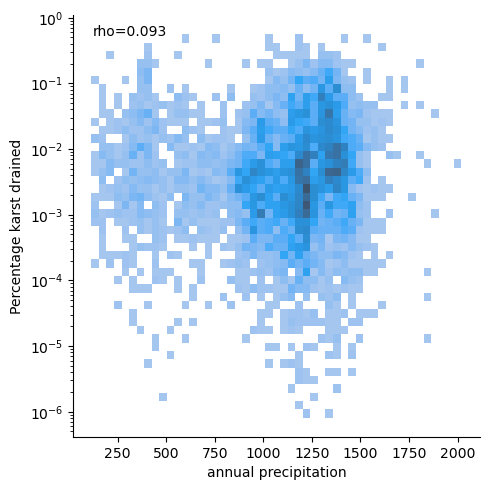

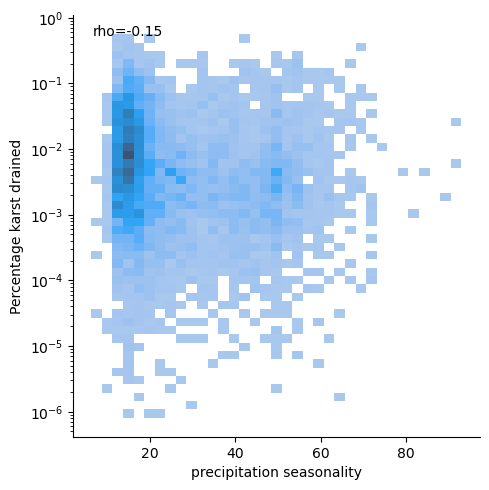

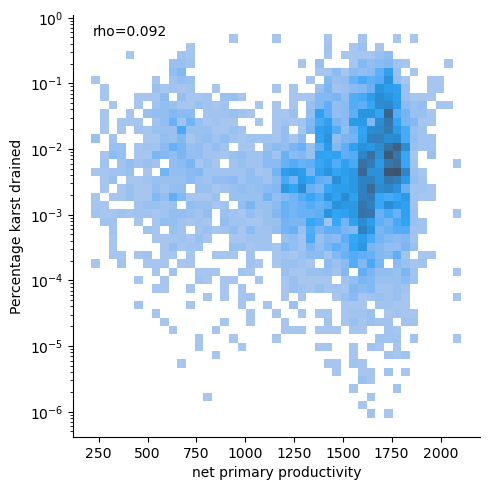

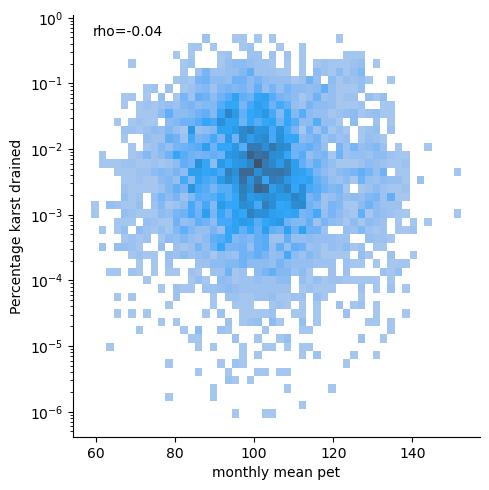

In [15]:
for param in raster_key.index:
     make_displot(param, 
             p_karst.copy(), 
             controls_df,
             trim_zero=True
        )

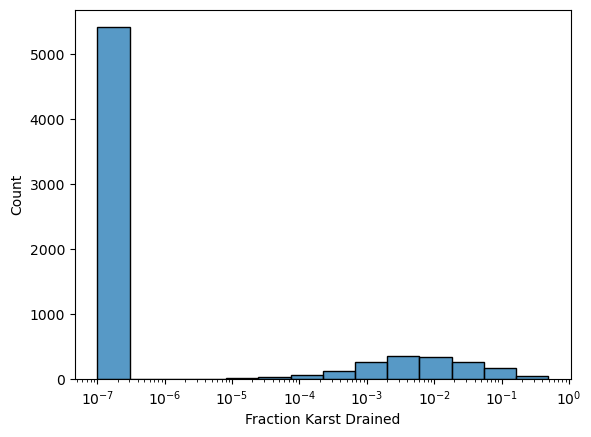

In [89]:
p_karst_no_zeros = p_karst.copy()
p_karst_no_zeros[p_karst_no_zeros==0] = 1e-7
sns.histplot(p_karst_no_zeros, log_scale=True)
plt.xlabel('Fraction Karst Drained')
plt.savefig('p_karst_hist.png')

<AxesSubplot: xlabel='p_karst', ylabel='Count'>

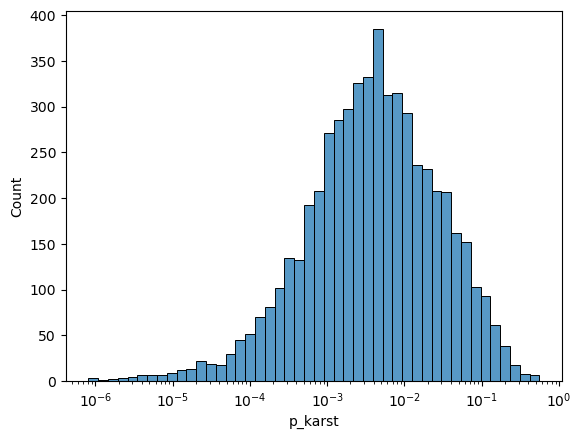

In [20]:
p_karst_trimmed = p_karst[p_karst>0].copy()

sns.histplot(p_karst_trimmed, log_scale=True)

In [2]:
import geopandas as gpd 
p_karst_rocks = gpd.read_file('processed_hucs_with_rocks_5070.shp')


In [1]:
p_karst_df_4326 =gpd.read_file('processed_hucs_with_climate_4326.shp')

NameError: name 'gpd' is not defined

In [4]:
import pandas as pd

In [5]:
different_cols = p_karst_rocks.columns.difference(p_karst_df_4326.columns)
keep_cols = different_cols.append(pd.Index(['huc12']))
p_karst_rocks[keep_cols]

,exposure,induration,percent_ar,rocktype1,rocktype2,unit_age,unit_name,huc12
0,E,Consolidated,0.999925,dolostone (dolomite),sand,Miocene,"""Hawthorn Formation""",030701040804
1,B3,Consolidated,0.999960,dolostone (dolomite),sandstone,Ordovician,Prairie du Chien Group,070900070103
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070300051102
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070300051004
4,B3,Consolidated,0.998908,shale,limestone,Lower Ordovician,Prairie du Chien Group,070300051005
...,...,...,...,...,...,...,...,...
29063,B3,Consolidated,0.551649,sandstone,dolostone (dolomite),Lower Devonian,Sylvania Sandstone,041000010201
29064,B3,Consolidated,1.000000,dolostone (dolomite),shale,Upper Silurian,Bass Island Dolomite,041000010206
29065,B3,Consolidated,0.665970,dolostone (dolomite),limestone,Silurian,Silurian,040400010606
29066,B3,Consolidated,0.937839,dolostone (dolomite),limestone,Silurian,Silurian,071200030306


In [6]:
different_cols = p_karst_rocks.columns.difference(p_karst_df_4326.columns)
keep_cols = different_cols.append(pd.Index(['huc12']))


p_rocks_and_climate = p_karst_rocks[keep_cols].merge(p_karst_df_4326, on='huc12', how='inner', copy=True)
p_rocks_and_climate

,exposure,induration,percent_ar,rocktype1,rocktype2,unit_age,unit_name,huc12,objectid,tnmid,...,p_karst,mean annua,mean diurn,isothermal,temperatur,annual pre,precipitat,net primar,monthly me,geometry
0,E,Consolidated,0.999925,dolostone (dolomite),sand,Miocene,"""Hawthorn Formation""",030701040804,12.0,{6505F355-D2F5-4F5B-B23D-28B9D65EDB67},...,0.0,19.050000,10.500000,0.376500,647.966667,1151.316667,20.400000,1564.133333,108.348333,"POLYGON ((-83.03813 31.78134, -83.03758 31.782..."
1,B3,Consolidated,0.999960,dolostone (dolomite),sandstone,Ordovician,Prairie du Chien Group,070900070103,27.0,{329AC928-B27E-451C-9894-0EA1323E83A5},...,0.0,9.750000,9.383333,0.248833,999.800000,919.083333,32.950000,1334.016667,91.533333,"POLYGON ((-89.15637 41.80703, -89.15473 41.806..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070300051102,42.0,{43CCC933-9A3E-4943-A5D4-38A2374DFF50},...,0.0,7.079577,9.250704,0.227394,1097.788732,869.397183,49.539437,1152.078873,84.902254,"MULTIPOLYGON (((-92.55104 45.02952, -92.55077 ..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070300051004,58.0,{7081B289-7E36-481F-A64D-18FBDE5DB836},...,0.0,6.800602,9.218072,0.226373,1099.648193,838.373494,47.892771,1128.595181,82.448675,"POLYGON ((-92.36683 45.14883, -92.36605 45.148..."
4,B3,Consolidated,0.998908,shale,limestone,Lower Ordovician,Prairie du Chien Group,070300051005,60.0,{37EC3111-2E10-4A97-B1C5-18EE0E4D054B},...,0.0,6.900000,9.200000,0.225000,1107.800000,834.100000,48.350000,1136.900000,84.380000,"POLYGON ((-92.49626 45.18376, -92.49644 45.184..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29063,B3,Consolidated,0.551649,sandstone,dolostone (dolomite),Lower Devonian,Sylvania Sandstone,041000010201,103569.0,{ED7FEC3A-64D8-4E88-B71D-BAC0AF2D08A7},...,0.0,10.123485,8.072727,0.228962,958.203030,952.582576,20.548485,1369.368939,89.584091,"MULTIPOLYGON (((-83.53500 41.94900, -83.53396 ..."
29064,B3,Consolidated,1.000000,dolostone (dolomite),shale,Upper Silurian,Bass Island Dolomite,041000010206,103570.0,{689F2122-77D4-46C1-87CB-24DABA95ACA2},...,0.0,10.171918,8.331507,0.235795,952.552055,953.108219,20.894521,1369.916438,90.368219,"POLYGON ((-83.47432 41.86106, -83.47170 41.861..."
29065,B3,Consolidated,0.665970,dolostone (dolomite),limestone,Silurian,Silurian,040400010606,104777.0,{B87206FE-1494-42F7-B646-18BA7F4900BF},...,0.0,10.350000,6.043750,0.176188,1005.928125,1082.531250,22.975000,1437.500000,91.606875,"MULTIPOLYGON (((-87.52895 41.73386, -87.52892 ..."
29066,B3,Consolidated,0.937839,dolostone (dolomite),limestone,Silurian,Silurian,071200030306,104780.0,{943FC0FF-C818-41FD-A5B6-FFE687FC836D},...,0.0,10.417742,7.674194,0.217419,979.367742,1059.496774,25.448387,1443.529032,83.995806,"POLYGON ((-87.51517 41.56213, -87.51525 41.562..."


In [40]:
limestones = p_rocks_and_climate[p_rocks_and_climate.rocktype1=='limestone']


In [43]:
raster_key.index.values

array(['mean annual temp', 'mean diurnal temp range', 'isothermality',
       'temperature seasonality', 'annual precipitation',
       'precipitation seasonality', 'net primary productivity',
       'monthly mean pet'], dtype=object)

In [119]:
raster_key.index

Index(['mean annua', 'mean diurn', 'isothermal', 'temperatur', 'annual pre',
       'precipitat', 'net primar', 'monthly me'],
      dtype='object', name='parameter')

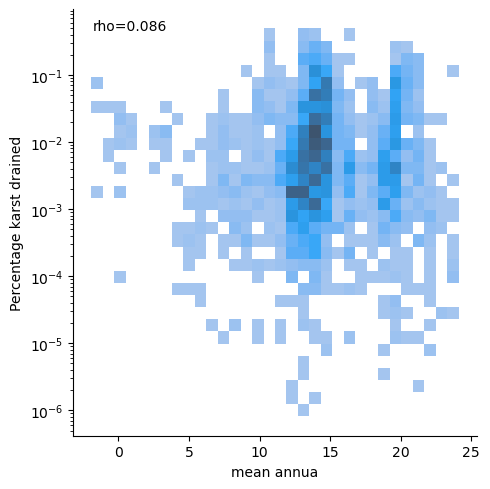

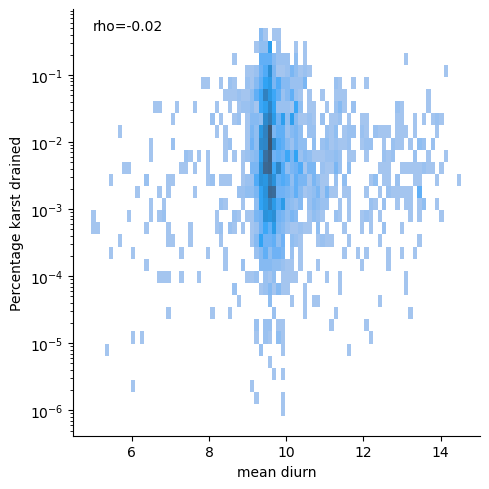

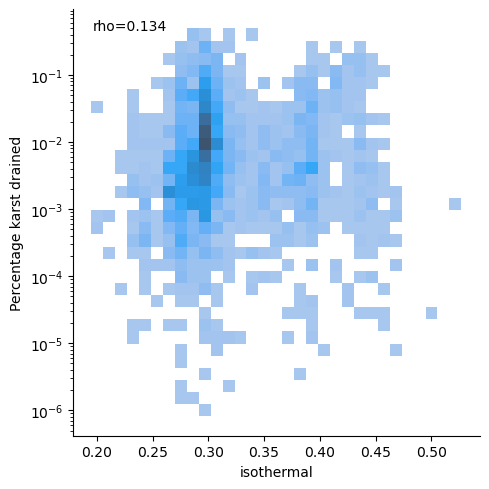

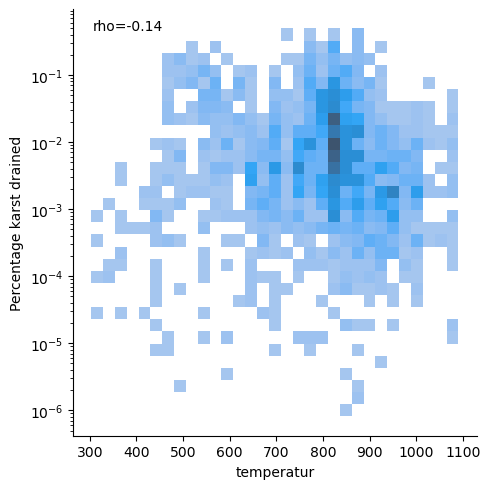

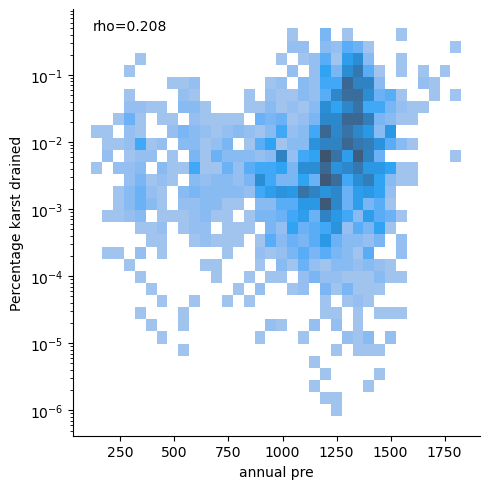

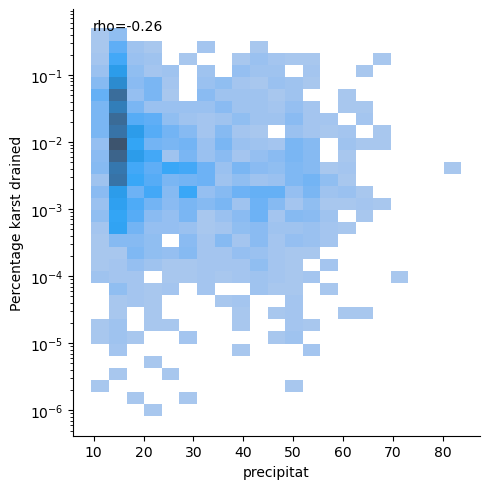

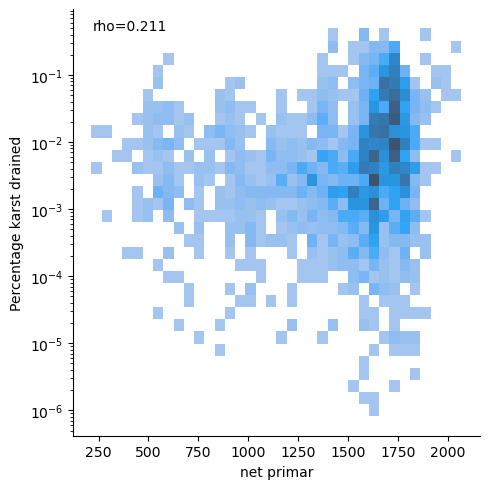

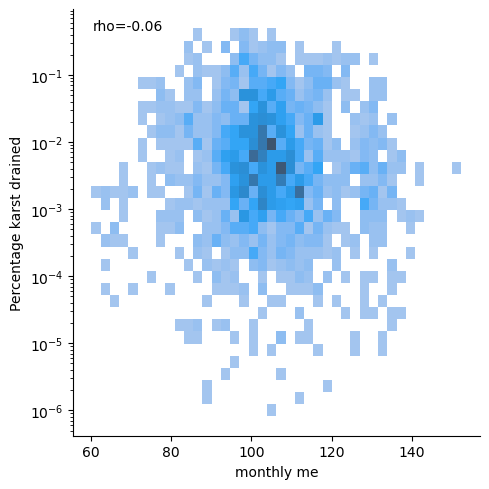

In [47]:
p_karst = limestones.p_karst
indep_vars = raster_key.index.values
for i, item in enumerate(indep_vars):
     indep_vars[i] = item[:10]
controls_df = limestones[indep_vars]



for param in raster_key.index:

     make_displot(param, 
             limestones.p_karst.copy(), 
             controls_df,
             ylabel='Fraction karst drained',
             xlabel=''
             #trim_zero=False,
             #set_zero_to=1e-7
        )

,mean annual temp,mean diurnal temp range,isothermality,temperature seasonality,annual precipitation,precipitation seasonality,net primary productivity,monthly mean pet
0,19.050000,10.500000,0.376500,647.966667,1151.316667,20.400000,1564.133333,108.348333
1,9.750000,9.383333,0.248833,999.800000,919.083333,32.950000,1334.016667,91.533333
2,7.079577,9.250704,0.227394,1097.788732,869.397183,49.539437,1152.078873,84.902254
3,6.800602,9.218072,0.226373,1099.648193,838.373494,47.892771,1128.595181,82.448675
4,6.900000,9.200000,0.225000,1107.800000,834.100000,48.350000,1136.900000,84.380000
...,...,...,...,...,...,...,...,...
29063,10.123485,8.072727,0.228962,958.203030,952.582576,20.548485,1369.368939,89.584091
29064,10.171918,8.331507,0.235795,952.552055,953.108219,20.894521,1369.916438,90.368219
29065,10.350000,6.043750,0.176188,1005.928125,1082.531250,22.975000,1437.500000,91.606875
29066,10.417742,7.674194,0.217419,979.367742,1059.496774,25.448387,1443.529032,83.995806


In [7]:
p_rocks_and_climate_no_zeros = p_rocks_and_climate[p_rocks_and_climate.p_karst>0]

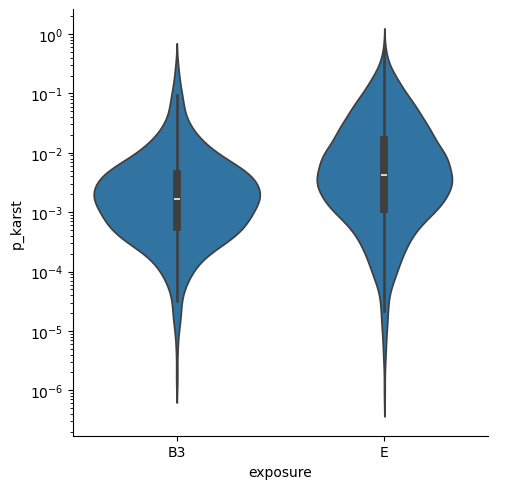

In [10]:
import seaborn as sns
fig = sns.catplot(p_rocks_and_climate_no_zeros, x='exposure', y='p_karst', kind='violin', log_scale=True)


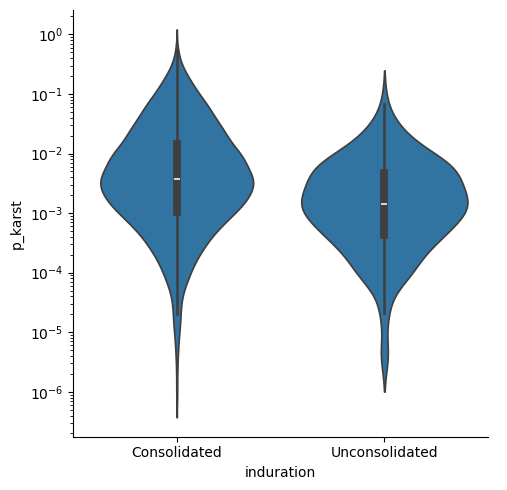

In [23]:
import seaborn as sns
fig = sns.catplot(p_rocks_and_climate_no_zeros, x='induration', y='p_karst', kind='violin', log_scale=True)


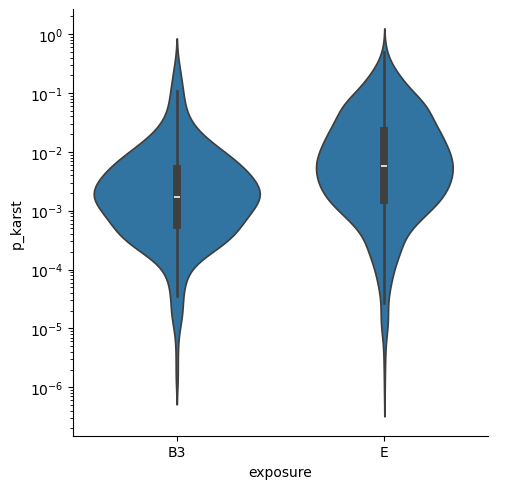

In [17]:
limestones_no_zeros = limestones[limestones.p_karst>0]
fig = sns.catplot(limestones_no_zeros, x='exposure', y='p_karst', kind='violin', log_scale=True)


In [18]:
high_karst = p_rocks_and_climate[p_rocks_and_climate.p_karst>0.1]
high_karst

,exposure,induration,percent_ar,rocktype1,rocktype2,unit_age,unit_name,huc12,objectid,tnmid,...,p_karst,mean annua,mean diurn,isothermal,temperatur,annual pre,precipitat,net primar,monthly me,geometry
114,E,Consolidated,0.699581,limestone,mudstone,Mississippian,Bangor Limestone,031601110208,659.0,{FB91FFD5-90BF-498A-8799-EFD70BC6AB96},...,0.157097,16.207447,9.659574,0.331787,719.863830,1533.953191,12.731915,1875.006383,104.088936,"MULTIPOLYGON (((-86.65982 34.00609, -86.66023 ..."
130,E,Consolidated,0.663610,limestone,dolostone (dolomite),Eocene,Ocala Limestone,030801020600,779.0,{029F94FE-455D-4B35-A421-70EB5548307C},...,0.162404,20.860720,9.905666,0.434069,493.870138,1326.950077,45.451761,1716.738132,123.257274,"MULTIPOLYGON (((-82.22841 29.37574, -82.22803 ..."
134,E,Consolidated,0.612878,limestone,dolostone (dolomite),Eocene,Ocala Limestone,030801020900,783.0,{01D92268-C3C0-4085-92D3-6A3F228EB241},...,0.131130,20.509588,10.090309,0.432513,507.433196,1320.955876,43.146598,1711.786392,117.089732,"POLYGON ((-82.54581 29.53126, -82.54540 29.531..."
137,E,Consolidated,0.677525,limestone,dolostone (dolomite),Eocene,Ocala Limestone,031002080800,789.0,{98AECB9A-D0B9-4E6D-AB2C-B466B36B74E6},...,0.117040,21.157227,9.702148,0.432711,485.917383,1313.852539,47.169141,1705.930078,124.533262,"MULTIPOLYGON (((-82.08307 29.18718, -82.08304 ..."
138,E,Consolidated,0.999948,limestone,dolostone (dolomite),Eocene,Ocala Limestone,031101010202,790.0,{7256A945-0867-4D30-B2DE-32743D97C4F2},...,0.216953,20.364583,10.293750,0.432146,520.520833,1322.768750,42.533333,1713.322917,121.667500,"POLYGON ((-82.56070 29.61843, -82.56017 29.617..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120800050501,95348.0,{178061FE-6E4F-4F14-AD76-12C263E89DC9},...,0.109876,17.802174,12.621739,0.409435,739.569565,399.021739,45.091304,676.086957,134.272609,"MULTIPOLYGON (((-102.12335 31.69230, -102.1240..."
28404,E,Consolidated,0.727397,dolostone (dolomite),limestone,Cambrian-Ordovician,Chepultepec and Copper Ridge Formations,060102060305,97498.0,{FE994447-9D01-4777-BA2E-981313FA4703},...,0.154608,13.003659,9.496748,0.314829,759.536585,1302.331707,14.625203,1657.703252,93.301057,"MULTIPOLYGON (((-83.33334 36.70251, -83.33336 ..."
29007,E,Consolidated,1.000000,limestone,dolostone (dolomite),Eocene,Ocala Limestone,031002080704,102790.0,{17FA9547-833E-4EC2-B9A5-029221972A86},...,0.174452,21.350000,9.540000,0.431700,479.050000,1288.230000,48.610000,1684.580000,130.644000,"MULTIPOLYGON (((-82.03757 28.88924, -82.03821 ..."
29045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,031002070203,102868.0,{333CC6D0-96AB-4261-961B-029EA3A4C251},...,0.187124,21.361765,9.582353,0.439765,475.773529,1343.947059,52.770588,1730.661765,119.885588,"MULTIPOLYGON (((-82.44276 28.71587, -82.44208 ..."


In [19]:
high_karst.rocktype1.unique()

array(['limestone', 'sand', 'shale', nan, 'sandstone',
       'dolostone (dolomite)', 'carbonate', 'fine-grained mixed clastic'],
      dtype=object)

In [20]:
high_karst.rocktype2.unique()

array(['mudstone', 'dolostone (dolomite)', 'clay or mud', 'shale',
       'limestone', nan, 'sandstone', 'clastic',
       'fine-grained mixed clastic', 'dolostone', 'chert'], dtype=object)

In [37]:
exposed_limestone = limestones[limestones.exposure=='E']


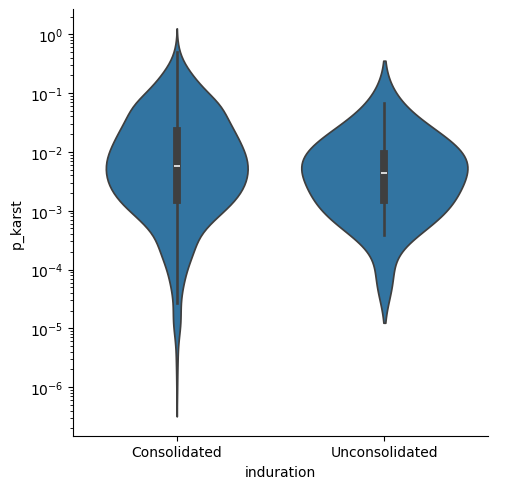

In [38]:
exposed_limestones_no_zeros = exposed_limestone[exposed_limestone.p_karst>0]
fig = sns.catplot(exposed_limestones_no_zeros, x='induration', y='p_karst', kind='violin', log_scale=True)


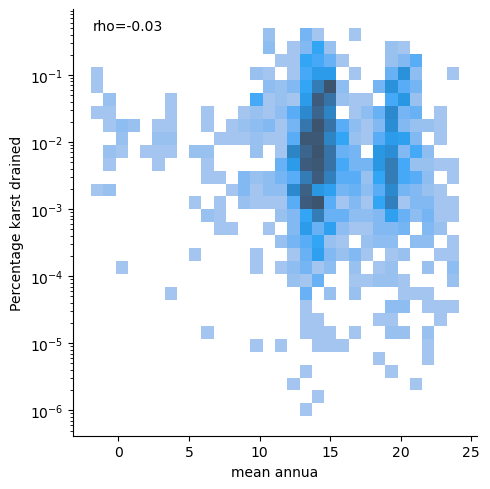

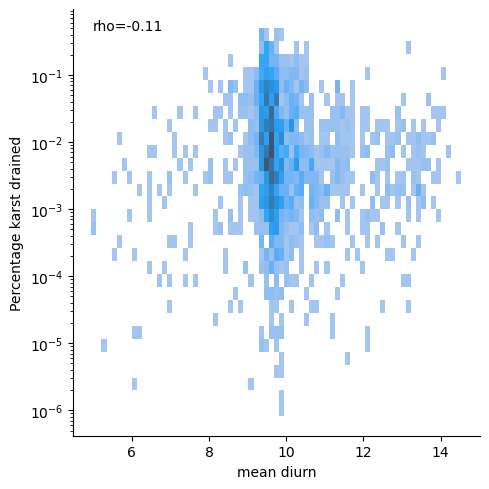

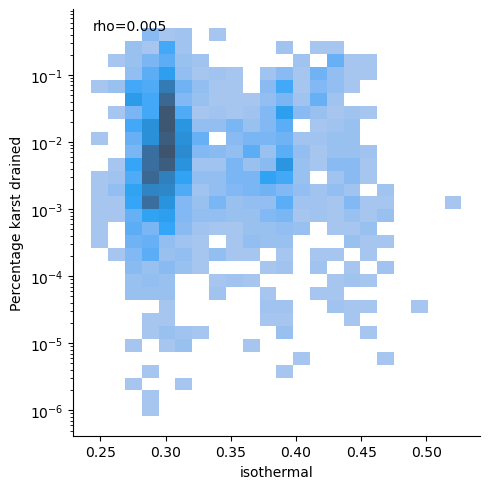

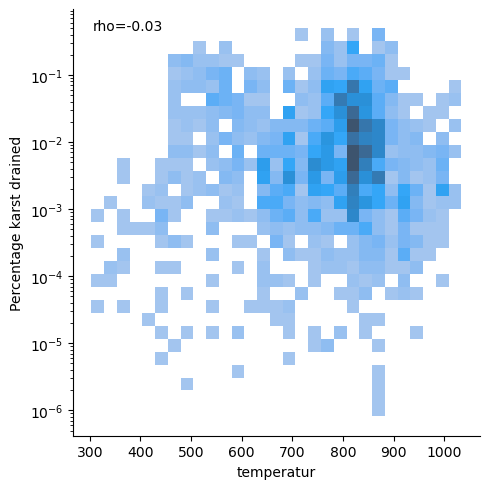

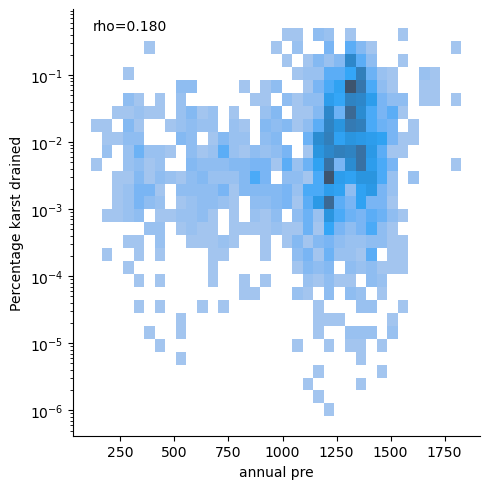

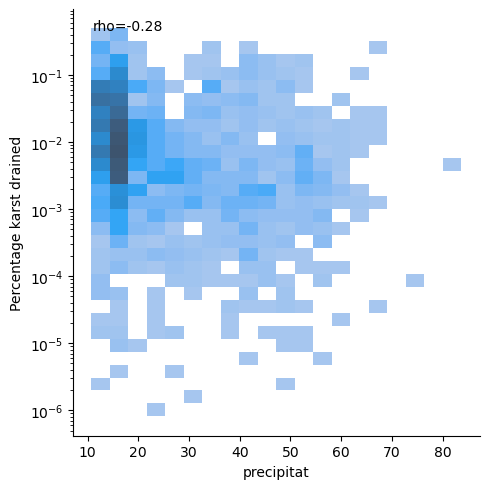

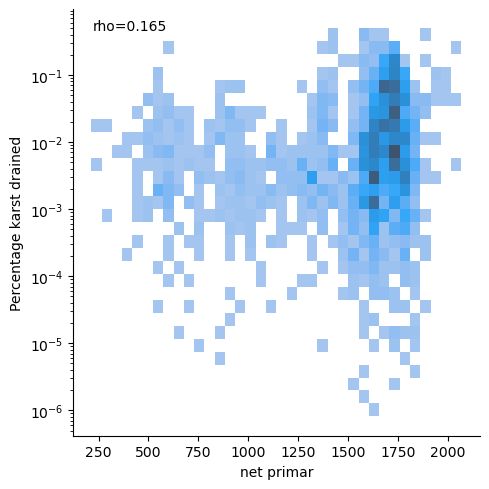

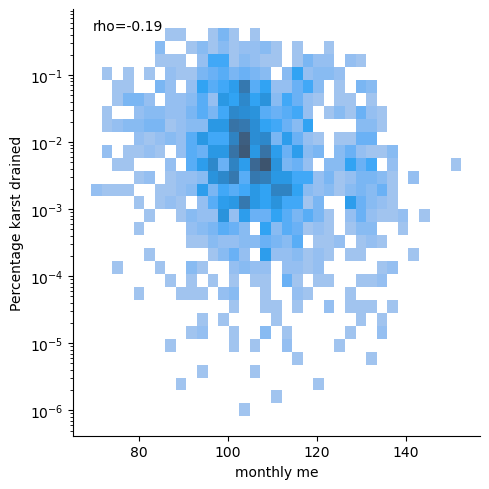

In [50]:
p_karst = exposed_limestone.p_karst
#indep_vars = raster_key.index.values
controls_df = exposed_limestone[indep_vars]

for param in raster_key.index:
     make_displot(param, 
             exposed_limestone.p_karst.copy(), 
             controls_df,
             #trim_zero=False,
             #set_zero_to=1e-7
        )

In [25]:
unconsolidated = p_karst_rocks[p_karst_rocks.induration=='Unconsolidated']

In [31]:
unconsolidated.rocktype1.unique()

array(['sand', 'mixed clastic/carbonate', 'carbonate', 'clay or mud',
       'limestone', 'terrace'], dtype=object)

In [28]:
unconsolidated.unit_name.unique()

array(['Chesapeake Group', 'Jackson Group',
       'Selma Group; Mooreville Chalk', 'Selma Group; Demopolis Chalk',
       'Marlbrook Marl', 'Midway Group; Porters Creek Formation',
       'Selma Group; Prairie Bluff Chalk', 'Arkadelphia Marl',
       'Eocene undifferentiated',
       'Lower Tertiary-Cretaceous undifferentiated',
       'Chesapeake Group; Choptank Formation',
       'Chesapeake Group; Calvert Formation', 'Lower Tertiary Deposits',
       'Austin Chalk', 'Cooper Marl',
       'Pleistocene-Pliocene sands and gravels',
       'Porters Creek formation', 'McBean Formation',
       'Black Creek Formation', 'Duplin Formation',
       'Middendorf Formation', 'Pecan Gap Chalk',
       'Gober Chalk and Roxton Limestone', 'Mt. Laurel Formation',
       'Demopolis Formation', 'Annona Chalk', 'Ector Chalk',
       'Huber/Lisbon/Barnwell Formations, undivided',
       'Vincentown Formation', 'Brownstown Marl', 'Nacatoch Sand',
       'Demopolis chalk', 'Mooreville chalk',
       'Pr

In [61]:
p_rocks_and_climate['nonzero'] = p_rocks_and_climate.p_karst>0

In [62]:
p_rocks_and_climate['nonzero']

0          False
1          False
2          False
3          False
4          False
           ...  
29064      False
29065      False
29066      False
29067      False
nonzero    False
Name: nonzero, Length: 29069, dtype: bool

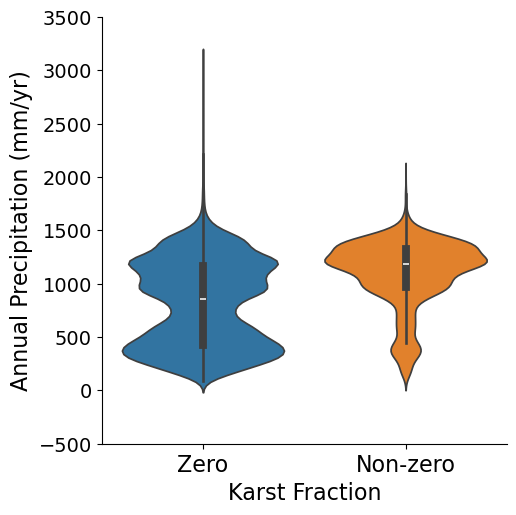

In [118]:
def nz_formatter(nonzero):
    if nonzero:
        return 'Non-zero'
    else:
        return 'Zero'
    
g=sns.catplot(p_rocks_and_climate, x='nonzero', y='annual pre', kind='violin', formatter=nz_formatter, hue='nonzero', legend=False)
plt.ylabel('Annual Precipitation (mm/yr)', fontsize=16)
plt.xlabel('Karst Fraction', fontsize=16)

g.set_xticklabels(fontsize=16)
g.set_yticklabels(fontsize=14)

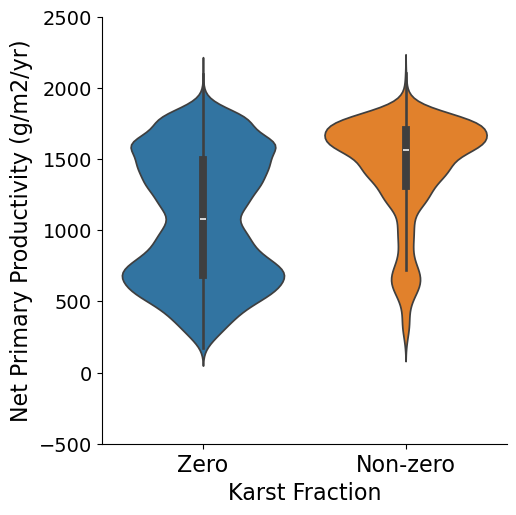

In [116]:
g=sns.catplot(p_rocks_and_climate, x='nonzero', y='net primar', kind='violin', hue ='nonzero', legend=False, formatter=nz_formatter )
plt.ylabel('Net Primary Productivity (g/m2/yr)', fontsize=16)
plt.xlabel('Karst Fraction', fontsize=16)
g.set_xticklabels(fontsize=16)
g.set_yticklabels(fontsize=14)

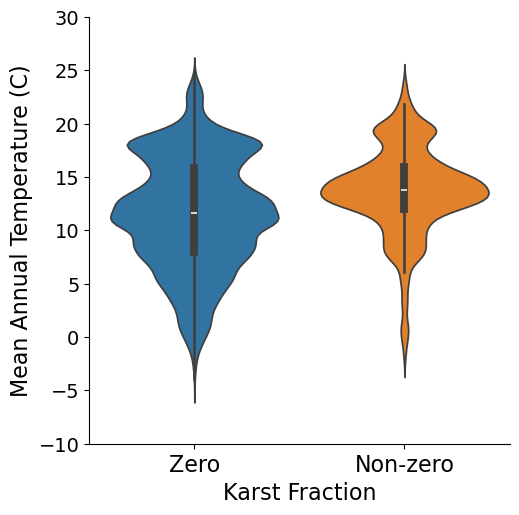

In [117]:
g= sns.catplot(p_rocks_and_climate, x='nonzero', y='mean annua', kind='violin', hue ='nonzero', legend=False , formatter=nz_formatter)
plt.ylabel('Mean Annual Temperature (C)', fontsize=16)
plt.xlabel('Karst Fraction', fontsize=16)

g.set_xticklabels(fontsize=16)
g.set_yticklabels(fontsize=14)

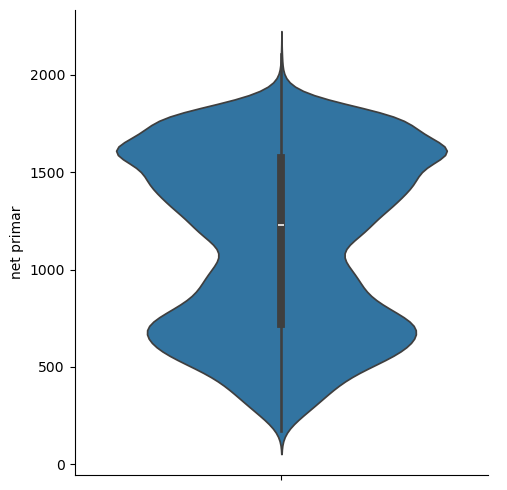

In [68]:
sns.catplot(p_rocks_and_climate, y='net primar', kind='violin')



<Axes: >

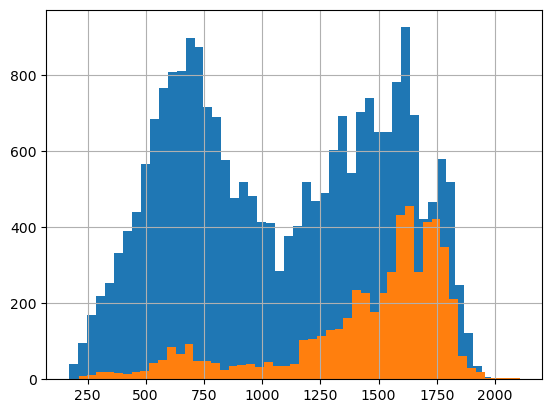

In [72]:
p_rocks_and_climate['net primar'][p_rocks_and_climate.p_karst==0].hist(bins=50)
p_rocks_and_climate['net primar'][p_rocks_and_climate.p_karst>0].hist(bins=50)


In [73]:
p_rocks_and_climate.rocktype1.unique()

array(['dolostone (dolomite)', nan, 'shale', 'limestone', 'sandstone',
       'carbonate', 'sand', 'clay or mud', 'siltstone', 'argillite',
       'conglomerate', 'mixed clastic/carbonate', 'calcarenite',
       'mudstone', 'marble', 'silt', 'residuum',
       'fine-grained mixed clastic', 'medium-grained mixed clastic',
       'meta-argillite', 'chert', 'schist', 'mica schist', 'slate',
       'clastic', 'dolostone', 'arkose', 'gneiss', 'olistostrome',
       'metasedimentary rock', 'arenite', 'quartzite', 'calcareous sand',
       'calc-silicate rock', 'sedimentary rock', 'phyllite', 'claystone',
       'biotite gneiss', 'mylonite', 'black shale', 'greenstone',
       'serpentinite', 'Sandstone', 'gravel', 'rhyolite', 'hornfels',
       'terrace', 'dolomite', 'landslide', 'graywacke', 'orthoquartzite',
       'melange'], dtype=object)

In [74]:
limestones = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='limestone']
sandstones = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='sandstone']
shale = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='shale']
dolomite = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='dolostone (dolomite)']

/tmp/ipykernel_411263/1195931056.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  limestones = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='limestone']
/tmp/ipykernel_411263/1195931056.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sandstones = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='sandstone']
/tmp/ipykernel_411263/1195931056.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shale = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='shale']
/tmp/ipykernel_411263/1195931056.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dolomite = p_rocks_and_climate_no_zeros[p_rocks_and_climate.rocktype1=='dolostone (dolomite)']


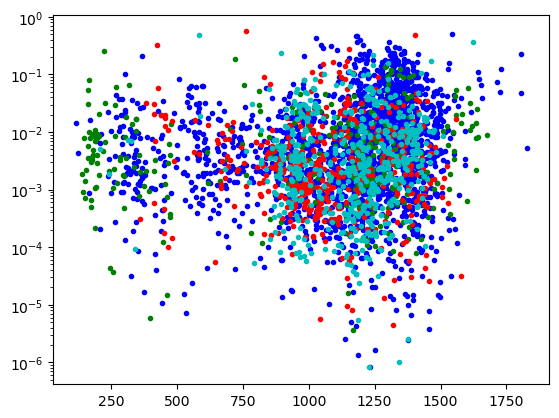

In [81]:

plt.semilogy(limestones['annual pre'], limestones.p_karst, '.', color='b')
plt.semilogy(sandstones['annual pre'], sandstones.p_karst, '.', color='g')
plt.semilogy(shale['annual pre'], shale.p_karst, '.', color='r')
plt.semilogy(dolomite['annual pre'], dolomite.p_karst, '.', color='c')

(1e-06, 1)

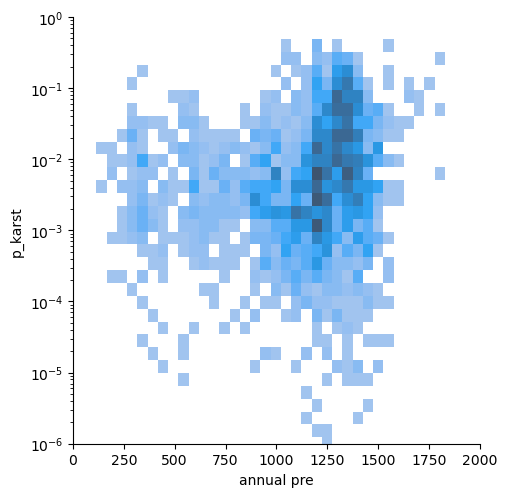

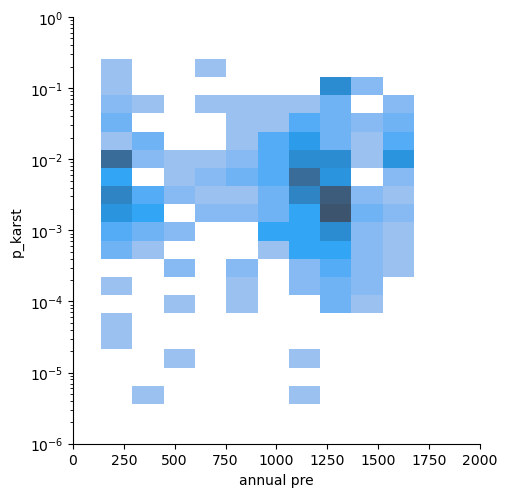

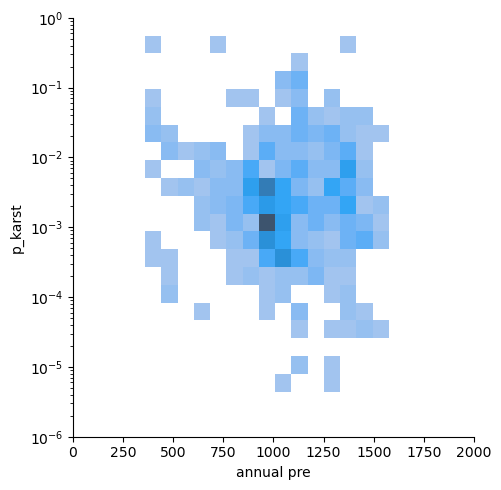

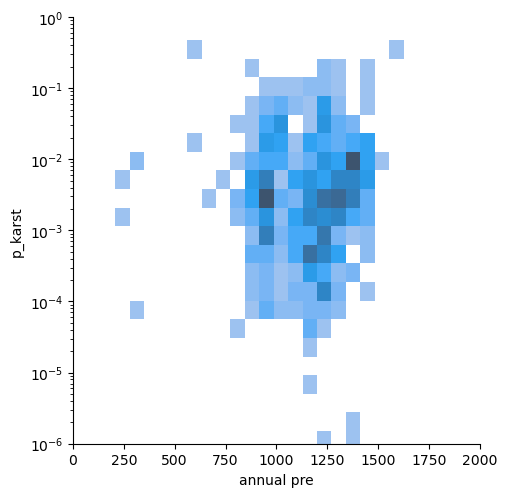

In [87]:
sns.displot(x=limestones['annual pre'], y=limestones.p_karst, log_scale=(False, True))
plt.xlim(0,2000)
plt.ylim(1e-6,1)
sns.displot(x=sandstones['annual pre'], y=sandstones.p_karst, log_scale=(False, True))
plt.xlim(0,2000)
plt.ylim(1e-6,1)
sns.displot(x=shale['annual pre'], y=shale.p_karst, log_scale=(False, True))
plt.xlim(0,2000)
plt.ylim(1e-6,1)
sns.displot(x=dolomite['annual pre'], y=dolomite.p_karst, log_scale=(False, True))
plt.xlim(0,2000)
plt.ylim(1e-6,1)
#plt.semilogy(sandstones['annual pre'], sandstones.p_karst, '.', color='g')
#plt.semilogy(shale['annual pre'], shale.p_karst, '.', color='r')
#plt.semilogy(dolomite['annual pre'], dolomite.p_karst, '.', color='c')

### Testing planetary computer to get soils data

Seems like it will be very slow. Perhaps better to work with csv files of tables.

In [11]:
#geom = p_karst_df.iloc[0].geometry
p_karst_WGS84 = p_karst_df.to_crs('WGS84')
geom = p_karst_WGS84.iloc[0]


In [16]:
import shapely
huc_json = shapely.to_geojson(geom)


In [4]:
#huc_json = p_karst_df.iloc[[0]].to_json()

In [41]:
import pystac_client
import planetary_computer
import rioxarray

In [5]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


In [6]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)


/home/mcoving/anaconda3/envs/geo/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


8

In [33]:
search = catalog.search(collections=["gnatsgo-rasters"], intersects=huc_json)
#search.item_collection()

In [35]:
items = list[search.item_collection()]
raster_item = items[0]
raster_item.assets.keys()

TypeError: There are no type variables left in list[<pystac.item_collection.ItemCollection object at 0x7fddc3ae2c10>]

In [37]:
items = search.item_collection_as_dict()

In [38]:
items

{'type': 'FeatureCollection',
 'features': [{'id': 'conus_1084485_1089185_1248325_925345',
   'bbox': [-84.60810697, 30.62894985, -82.66783607, 32.27931226],
   'type': 'Feature',
   'links': [{'rel': 'collection',
     'type': 'application/json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/gnatsgo-rasters'},
    {'rel': 'parent',
     'type': 'application/json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/gnatsgo-rasters'},
    {'rel': 'root',
     'type': 'application/json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/'},
    {'rel': 'self',
     'type': 'application/geo+json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/gnatsgo-rasters/items/conus_1084485_1089185_1248325_925345'},
    {'rel': 'handbook',
     'href': 'https://www.nrcs.usda.gov/wps/PA_NRCSConsumption/download?cid=nrcs142p2_051847&ext=pdf',
     'type': 'application/pdf',
     'title': 'gSSURGO U

In [40]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["gnatsgo-rasters"],
    intersects=huc_json,
)
items = list(search.get_items())
print(f"Returned {len(items)} item")
raster_item = items[0]
print(list(raster_item.assets.keys()))

/home/mcoving/anaconda3/envs/geo/lib/python3.9/site-packages/pystac_client/item_search.py:836: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Returned 1 item
['mukey', 'aws0_5', 'soc0_5', 'tk0_5a', 'tk0_5s', 'aws0_20', 'aws0_30', 'aws5_20', 'soc0_20', 'soc0_30', 'soc5_20', 'tk0_20a', 'tk0_20s', 'tk0_30a', 'tk0_30s', 'tk5_20a', 'tk5_20s', 'aws0_100', 'aws0_150', 'aws0_999', 'aws20_50', 'droughty', 'nccpi3sg', 'soc0_100', 'soc0_150', 'soc0_999', 'soc20_50', 'tk0_100a', 'tk0_100s', 'tk0_150a', 'tk0_150s', 'tk0_999a', 'tk0_999s', 'tk20_50a', 'tk20_50s', 'aws50_100', 'musumcpct', 'nccpi3all', 'nccpi3cot', 'nccpi3soy', 'pwsl1pomu', 'rootznaws', 'rootznemc', 'soc50_100', 'tk50_100a', 'tk50_100s', 'aws100_150', 'aws150_999', 'musumcpcta', 'musumcpcts', 'nccpi3corn', 'pctearthmc', 'soc100_150', 'soc150_999', 'tk100_150a', 'tk100_150s', 'tk150_999a', 'tk150_999s', 'tilejson', 'rendered_preview']


In [43]:
raster_item

<Item id=conus_1084485_1089185_1248325_925345>

In [46]:
signed_asset = raster_item.assets["soc0_20"]
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 8, "x": 8})
    .mean()
)

print(raster_item.assets["soc0_20"].description)
data.plot.imshow(vmin=0, add_labels=False)

TypeError: '>=' not supported between instances of 'float' and 'Polygon'